In [1]:
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
from torch.optim import SGD, Adam
from torchvision import datasets
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
seed = 1
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
data_dir = "./data/"
reduce_data_size = True

mnist_train_set = datasets.MNIST(data_dir + 'mnist/',
                                 train=True,
                                 download=True)
mnist_test_set = datasets.MNIST(data_dir + 'mnist/',
                                train=False,
                                download=True)

mnist_train_input = mnist_train_set.data.view(-1, 1, 28, 28).float()
mnist_train_target = mnist_train_set.targets
mnist_test_input = mnist_test_set.data.view(-1, 1, 28, 28).float()
mnist_test_target = mnist_test_set.targets

fashion_mnist_train_set = datasets.FashionMNIST(data_dir + 'fashion_mnist/',
                                                train=True,
                                                download=True)
fashion_mnist_test_set = datasets.FashionMNIST(data_dir + 'fashion_mnist/',
                                               train=False,
                                               download=True)

fashion_mnist_train_input = fashion_mnist_train_set.data.view(-1, 1, 28, 28).float()
fashion_mnist_train_target = fashion_mnist_train_set.targets
fashion_mnist_test_input = fashion_mnist_test_set.data.view(-1, 1, 28, 28).float()
fashion_mnist_test_target = fashion_mnist_test_set.targets

In [4]:
def standardize_data(train_input, test_input):
    mean, std = train_input.mean(), train_input.std()

    return (train_input - mean) / std, (test_input - mean) / std

In [5]:
def sample_mnist_dataset(input_data, target_data, reduced_num_samples=1000):
    reduced_input_data, _, reduced_target_data, _ = train_test_split(input_data, target_data,
                                                                     train_size=reduced_num_samples,
                                                                     random_state=1,
                                                                     shuffle=True,
                                                                     stratify=target_data)
    return reduced_input_data, reduced_target_data

In [6]:
class MnistClassifier(nn.Module):
    def __init__(self, mini_batch_size=100):
        nn.Module.__init__(self)
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3)
        self.maxp1 = nn.MaxPool2d(kernel_size=2)
        if mini_batch_size > 1:
            self.bn1 = nn.BatchNorm2d(num_features=16)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=4)
        self.maxp2 = nn.MaxPool2d(kernel_size=2)
        if mini_batch_size > 1:
            self.bn2 = nn.BatchNorm2d(num_features=32)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5)
        if mini_batch_size > 1:
            self.bn3 = nn.BatchNorm1d(num_features=64)
        self.fc1 = nn.Linear(in_features=64, out_features=256)
        if mini_batch_size > 1:
            self.bn4 = nn.BatchNorm1d(num_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=10)

    def forward(self, x):
        mini_batch_size = x.size(0)
        y = F.relu(self.maxp1(self.conv1(x)))
        if mini_batch_size > 1:
            y = self.bn1(y)
        y = F.relu(self.maxp2(self.conv2(y)))
        if mini_batch_size > 1:
            y = self.bn2(y)
        y = F.relu(self.conv3(y).view(-1, 64))
        if mini_batch_size > 1:
            y = self.bn3(y)
        y = F.relu(self.fc1(y))
        if mini_batch_size > 1:
            y = self.bn4(y)
        y = F.relu(self.fc2(y))
        return y

In [7]:
def deep_model_param_loss_gradients_to_flat_vector(model_params):
    return torch.cat([param.grad.view(-1).cpu() for param in model_params])

In [8]:
class SgdToHalf(torch.optim.Optimizer):
    def __init__(self, params, lr, burn_in=10):
        self.params = params
        self.lr = lr
        self.burn_in = burn_in
        self.n = 1
        self.s = [0, ]
        self.tau = 0
        self.prev_grad = None
        defaults = {"lr": lr, "burn_in": burn_in, "n": 1, "s": [0, ], "tau": 0, "prev_grad": None}
        super(SgdToHalf, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(SgdToHalf, self).__setstate__(state)
        
    @torch.no_grad()
    def step(self, closure=None):
        """Performs a single optimization step.

        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        group = self.param_groups[0]
        lr = group["lr"]
        burn_in = group["burn_in"]
        n = group["n"]
        s = float(group["s"][-1])
        tau = group["tau"]
        
        params = group["params"]
        for p in params:
            if p.grad is None:
                continue
            g_p = p.grad
            p.add_(g_p, alpha=-lr)
        
        g = deep_model_param_loss_gradients_to_flat_vector(params)
        if n == 1:
            self.prev_grad = group["prev_grad"] = torch.clone(g).detach()
        else:
            g_prev = group["prev_grad"]
            s += torch.dot(g.view(-1), g_prev.view(-1))
            if n > (tau + burn_in) and s < 0:
                self.tau = group["tau"] = n
                s = 0
                self.lr = group["lr"] = lr / 2
            self.s.append(s)
            group["s"].append(s)
            self.prev_grad = group["prev_grad"] = torch.clone(g).detach()
            
        self.n = group["n"] = n+1
                
        return loss

    def converged(self):
        return self.n > (self.tau + self.burn_in) and self.s[-1] < 0 and self.lr < 1e-10

In [9]:
def train_model(model, train_input, train_target,
                num_epochs=25, lr=1e-1, mini_batch_size=100,
                adam=False, sgd_new=False, criterion=nn.CrossEntropyLoss()):
    if adam:
        optimizer = Adam(model.parameters(), lr=lr)
    else:
        if sgd_new:
            optimizer = SgdToHalf(model.parameters(), lr=lr)
        else:
            optimizer = SGD(model.parameters(), lr=lr)
    criterion = criterion.cuda()
    num_samples = train_input.size(0)
    loss_gradients_series=[]
    converged_early = False
    for e in range(1, num_epochs+1):
        if converged_early:
            break
        sum_loss=0
        for b in range(0, num_samples, mini_batch_size):
            train_input_mini_batch = train_input[b:min(b+mini_batch_size, num_samples)]
            train_target_mini_batch = train_target[b:min(b+mini_batch_size, num_samples)]
            optimizer.zero_grad()
            prediction_mini_batch = model(train_input_mini_batch)
            loss = criterion(prediction_mini_batch, train_target_mini_batch)
            sum_loss += loss.item()
            loss.backward()
            with torch.no_grad():
                loss_gradients = deep_model_param_loss_gradients_to_flat_vector(model.parameters())
                loss_gradients_series.append(loss_gradients)
            optimizer.step()
            torch.cuda.empty_cache()
            if sgd_new and optimizer.converged():
                converged_early = True
                break
        print("Epoch {} Loss: {}".format(e, sum_loss))
    loss_gradients_series = torch.stack(loss_gradients_series)
    if sgd_new:
        print("Convergence reached at iteration:", optimizer.tau)
        print("Final learning rate value:", optimizer.lr)
        return model, loss_gradients_series, torch.FloatTensor(optimizer.s)
    else:
        return model, loss_gradients_series

In [10]:
def test_model(model, test_input, test_target):
    model.train(False)
    prediction = model(test_input)
    predicted_labels = torch.argmax(prediction, dim=1)
    if len(test_target.size()) > 1:
        test_target = torch.argmax(test_target, dim=1)
    accuracy = (predicted_labels == test_target).float().mean().item()
    return accuracy

In [11]:
def estimate_convergence_threshold_phlug_diagnostic(loss_gradients_series, burn_in=1):
    num_sgd_iterations_performed = len(loss_gradients_series)
    s_series = [0, ]
    convergence_threshold_set=False
    convergence_threshold = np.inf
    for n in range(1, num_sgd_iterations_performed):
        s_n = s_series[n-1] + torch.dot(loss_gradients_series[n], loss_gradients_series[n-1]).item()
        s_series.append(s_n)
        if not convergence_threshold_set and n > burn_in and s_n < 0:
            convergence_threshold = n
            convergence_threshold_set = True
    s_series = np.array(s_series)
    return convergence_threshold, s_series

In [12]:
if reduce_data_size:
    mnist_train_input, mnist_train_target = sample_mnist_dataset(mnist_train_input, mnist_train_target)
    mnist_test_input, mnist_test_target = sample_mnist_dataset(mnist_test_input, mnist_test_target)
mnist_train_input, mnist_test_input = standardize_data(mnist_train_input, mnist_test_input)
mnist_train_input = mnist_train_input.cuda()
mnist_train_target = mnist_train_target.cuda()
mnist_test_input = mnist_test_input.cuda()
mnist_test_target = mnist_test_target.cuda()

In [13]:
mini_batch_size=100
mnist_model, mnist_training_loss_grads, mnist_s_series = train_model(MnistClassifier(mini_batch_size).cuda(),
                                                                     mnist_train_input,
                                                                     mnist_train_target,
                                                                     lr=0.5,
                                                                     num_epochs=100,
                                                                     mini_batch_size=mini_batch_size,
                                                                     sgd_new=True)

Epoch 1 Loss: 12.220357537269592
Epoch 2 Loss: 2.1943083330988884
Epoch 3 Loss: 0.8293740153312683
Epoch 4 Loss: 0.5036141946911812
Epoch 5 Loss: 0.3781593982130289
Epoch 6 Loss: 0.33714192174375057
Epoch 7 Loss: 0.31823820620775223
Epoch 8 Loss: 0.3095127120614052
Epoch 9 Loss: 0.30516389943659306
Epoch 10 Loss: 0.3029880169779062
Epoch 11 Loss: 0.3018596265465021
Epoch 12 Loss: 0.30128366127610207
Epoch 13 Loss: 0.3009942974895239
Epoch 14 Loss: 0.3008438013494015
Epoch 15 Loss: 0.30076457001268864
Epoch 16 Loss: 0.30071732215583324
Epoch 17 Loss: 0.30069215409457684
Epoch 18 Loss: 0.30067748203873634
Epoch 19 Loss: 0.30066972970962524
Epoch 20 Loss: 0.3006658498197794
Epoch 21 Loss: 0.30066389963030815
Epoch 22 Loss: 0.300662849098444
Epoch 23 Loss: 0.3006624858826399
Epoch 24 Loss: 0.3006623610854149
Epoch 25 Loss: 0.30066232196986675
Epoch 26 Loss: 0.30066230706870556
Epoch 27 Loss: 0.30066229216754436
Epoch 28 Loss: 0.3006622865796089
Epoch 29 Loss: 0.30066228471696377
Epoch 30 L

In [14]:
test_model(mnist_model, mnist_test_input, mnist_test_target)

0.9550000429153442

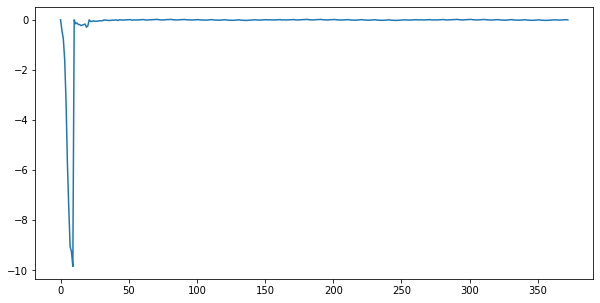

In [15]:
plt.figure(figsize=(10, 5))
sns.lineplot(data=mnist_s_series)
plt.show()

In [16]:
mnist_conv_thresh, mnist_s_series = estimate_convergence_threshold_phlug_diagnostic(mnist_training_loss_grads,
                                                                                    burn_in=10)
mnist_conv_thresh

11

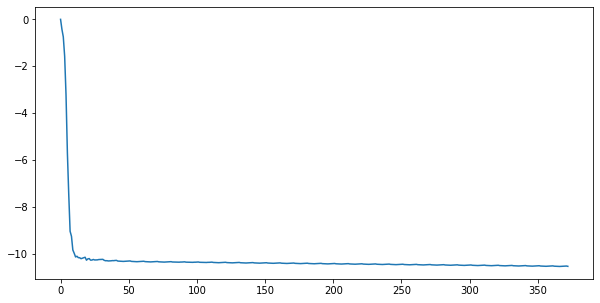

In [17]:
plt.figure(figsize=(10, 5))
sns.lineplot(data=mnist_s_series)
plt.show()

In [18]:
if reduce_data_size:
    fashion_mnist_train_input, fashion_mnist_train_target = sample_mnist_dataset(fashion_mnist_train_input,
                                                                                 fashion_mnist_train_target)
    fashion_mnist_test_input, fashion_mnist_test_target = sample_mnist_dataset(fashion_mnist_test_input,
                                                                               fashion_mnist_test_target)
fashion_mnist_train_input, fashion_mnist_test_input = standardize_data(fashion_mnist_train_input,
                                                                       fashion_mnist_test_input)
fashion_mnist_train_input = fashion_mnist_train_input.cuda()
fashion_mnist_train_target = fashion_mnist_train_target.cuda()
fashion_mnist_test_input = fashion_mnist_test_input.cuda()
fashion_mnist_test_target = fashion_mnist_test_target.cuda()

In [19]:
fashion_mnist_model, fashion_mnist_training_loss_grads, fashion_mnist_s_series = train_model(MnistClassifier(mini_batch_size).cuda(),
                                                                                             fashion_mnist_train_input,
                                                                                             fashion_mnist_train_target,
                                                                                             lr=0.05,
                                                                                             num_epochs=100,
                                                                                             mini_batch_size=mini_batch_size,
                                                                                             sgd_new=True)

Epoch 1 Loss: 13.211354374885559
Epoch 2 Loss: 6.4151251912117
Epoch 3 Loss: 4.65219709277153
Epoch 4 Loss: 3.489443004131317
Epoch 5 Loss: 2.7199286967515945
Epoch 6 Loss: 1.9340814054012299
Epoch 7 Loss: 1.5432416200637817
Epoch 8 Loss: 1.2332655563950539
Epoch 9 Loss: 0.9953883290290833
Epoch 10 Loss: 0.8141633868217468
Epoch 11 Loss: 0.6748586148023605
Epoch 12 Loss: 0.5690636299550533
Epoch 13 Loss: 0.4892520010471344
Epoch 14 Loss: 0.42744434624910355
Epoch 15 Loss: 0.3779377844184637
Epoch 16 Loss: 0.3394611570984125
Epoch 17 Loss: 0.3076034691184759
Epoch 18 Loss: 0.2816105652600527
Epoch 19 Loss: 0.2586976960301399
Epoch 20 Loss: 0.23997803777456284
Epoch 21 Loss: 0.22377495747059584
Epoch 22 Loss: 0.20905764121562243
Epoch 23 Loss: 0.19659019634127617
Epoch 24 Loss: 0.185500911436975
Epoch 25 Loss: 0.17562928516417742
Epoch 26 Loss: 0.1667641680687666
Epoch 27 Loss: 0.15885075833648443
Epoch 28 Loss: 0.15157821215689182
Epoch 29 Loss: 0.1450312277302146
Epoch 30 Loss: 0.13896

In [20]:
test_model(fashion_mnist_model, fashion_mnist_test_input, fashion_mnist_test_target)

0.7950000166893005

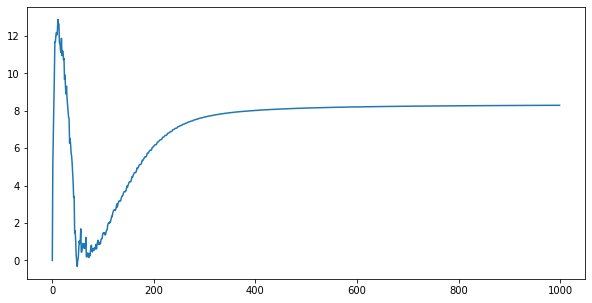

In [21]:
plt.figure(figsize=(10, 5))
sns.lineplot(data=fashion_mnist_s_series)
plt.show()

In [22]:
fashion_mnist_conv_thresh, fashion_mnist_s_series = estimate_convergence_threshold_phlug_diagnostic(fashion_mnist_training_loss_grads,
                                                                                                    burn_in=10)
fashion_mnist_conv_thresh

48

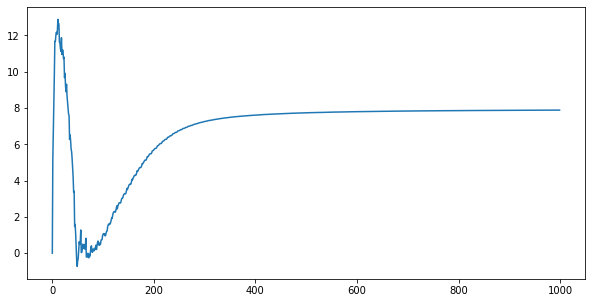

In [23]:
plt.figure(figsize=(10, 5))
sns.lineplot(data=fashion_mnist_s_series)
plt.show()

In [24]:
def generate_simple_linear_classification_dataset(num_samples=1000, num_features=10, onehot_targets=False):
    input_data = torch.empty(num_samples*2, num_features).uniform_(-1, 1)
    target_data = (input_data.mean(dim=1) > 0).long()
    if onehot_targets:
        target_data = F.one_hot(target_data, num_classes=2).float()
    return input_data[:num_samples], target_data[:num_samples], input_data[num_samples:], target_data[num_samples:]

In [25]:
linear_train_input, linear_train_target, linear_test_input, linear_test_target = generate_simple_linear_classification_dataset(onehot_targets=True)
linear_train_input, linear_test_input = standardize_data(linear_train_input, linear_test_input)
linear_train_input = linear_train_input.cuda()
linear_train_target = linear_train_target.cuda()
linear_test_input = linear_test_input.cuda()
linear_test_target = linear_test_target.cuda()

In [26]:
linear_model, linear_training_loss_grads, linear_s_series = train_model(nn.Sequential(nn.Linear(10, 2), nn.Sigmoid()).cuda(),
                                                                        linear_train_input,
                                                                        linear_train_target,
                                                                        sgd_new=True,
                                                                        num_epochs=100,
                                                                        lr=15, mini_batch_size=100,
                                                                        criterion=nn.MSELoss())

Epoch 1 Loss: 0.870960894972086
Epoch 2 Loss: 0.4488200806081295
Epoch 3 Loss: 0.37588435411453247
Epoch 4 Loss: 0.3350998219102621
Epoch 5 Loss: 0.3075245749205351
Epoch 6 Loss: 0.28581355698406696
Epoch 7 Loss: 0.26825895346701145
Epoch 8 Loss: 0.2598079200834036
Epoch 9 Loss: 0.25545332208275795
Epoch 10 Loss: 0.2532663643360138
Epoch 11 Loss: 0.2521296087652445
Epoch 12 Loss: 0.2515304312109947
Epoch 13 Loss: 0.25124859996140003
Epoch 14 Loss: 0.25108078867197037
Epoch 15 Loss: 0.25099143013358116
Epoch 16 Loss: 0.2509461008012295
Epoch 17 Loss: 0.25092254020273685
Epoch 18 Loss: 0.25090973265469074
Epoch 19 Loss: 0.25090260058641434
Epoch 20 Loss: 0.2508986368775368
Epoch 21 Loss: 0.2508965954184532
Epoch 22 Loss: 0.2508955132216215
Epoch 23 Loss: 0.2508949376642704
Epoch 24 Loss: 0.2508946694433689
Epoch 25 Loss: 0.2508945111185312
Epoch 26 Loss: 0.25089440681040287
Epoch 27 Loss: 0.2508943732827902
Epoch 28 Loss: 0.25089435651898384
Epoch 29 Loss: 0.25089434906840324
Epoch 30 Lo

In [27]:
test_model(linear_model, linear_test_input, linear_test_target)

0.9850000739097595

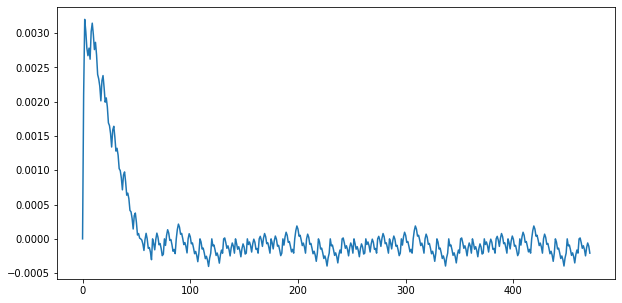

In [28]:
plt.figure(figsize=(10, 5))
sns.lineplot(data=linear_s_series)
plt.show()

In [29]:
linear_conv_thresh, linear_s_series = estimate_convergence_threshold_phlug_diagnostic(linear_training_loss_grads,
                                                                                      burn_in=10)
linear_conv_thresh

54

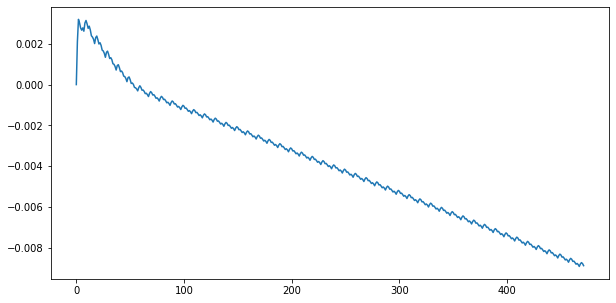

In [30]:
plt.figure(figsize=(10, 5))
sns.lineplot(data=linear_s_series)
plt.show()